In [7]:
from IPython import display
import time
import tensorflow as tf
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cross_validation import train_test_split
from skimage import transform, io, color, feature
%matplotlib inline
sns.set_style("whitegrid", {'axes.grid': False})

/Users/yossy/.pyenv/versions/anaconda2-4.0.0/envs/tensorflow/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
PATH_IMG = "/home/naotoyoshida/udacity/Self-Driving-Car-Behavior-Cloning/drivedata/"
CSV_PATH = 'drivedata/driving_log.csv'
data = pd.read_csv(CSV_PATH,
                names=['img_center', 'img_left', 'img_right',
                        'steer_angle', 'throttle', 'brake', 'speed'],
                sep=', ', engine='python')

print(data[:3])
data.reindex(np.random.permutation(data.index)).reset_index(drop=True)

# remove zero-steering
msk = np.abs(data['steer_angle']) > 0.00001
data_nonzeroXc = data['img_center'][msk]
data_nonzeroXl = data['img_left'][msk]
data_nonzeroXr = data['img_right'][msk]
data_nonzeroy = data['steer_angle'][msk]

# get train-test split mask
msk = np.linspace(0,1,len(data_nonzeroy)) < 0.8
# Trainnig data with data augumentation
Xc_train_info = data_nonzeroXc[msk].as_matrix()
Xl_train_info = data_nonzeroXl[msk].as_matrix()
Xr_train_info = data_nonzeroXr[msk].as_matrix()
X_train_info = np.concatenate((Xc_train_info,
                               Xl_train_info,
                               Xr_train_info))
y_train_info = data_nonzeroy[msk].as_matrix()
y_train_info = np.concatenate((y_train_info,
                               y_train_info,
                               y_train_info))

# Validation Data without data augumentation
X_val_info = data_nonzeroXc[~msk].as_matrix()
y_val_info = data_nonzeroy[~msk].as_matrix()

print(Xc_train_info.shape)
print(X_train_info.shape)
print(y_train_info.shape)
print(X_val_info.shape)
print(y_val_info.shape)
print("train")
print(X_train_info[:3])
print(y_train_info[:10])
print("val")
print(X_val_info[:3])
print(y_val_info[:10])

n_train = X_train_info.shape[0]
n_val = X_val_info.shape[0]

                                          img_center  \
0  /home/naotoyoshida/udacity/Self-Driving-Car-Be...   
1  /home/naotoyoshida/udacity/Self-Driving-Car-Be...   
2  /home/naotoyoshida/udacity/Self-Driving-Car-Be...   

                                            img_left  \
0  /home/naotoyoshida/udacity/Self-Driving-Car-Be...   
1  /home/naotoyoshida/udacity/Self-Driving-Car-Be...   
2  /home/naotoyoshida/udacity/Self-Driving-Car-Be...   

                                           img_right  steer_angle  throttle  \
0  /home/naotoyoshida/udacity/Self-Driving-Car-Be...          0.0       0.0   
1  /home/naotoyoshida/udacity/Self-Driving-Car-Be...          0.0       0.0   
2  /home/naotoyoshida/udacity/Self-Driving-Car-Be...          0.0       0.0   

   brake     speed  
0      0  2.190392  
1      0  2.166651  
2      0  2.143156  
(2509,)
(7527,)
(7527,)
(627,)
(627,)
train
[ '/home/naotoyoshida/udacity/Self-Driving-Car-Behavior-Cloning/drivedata/IMG/center_2017_02_05_23_23_09_

[[[  6.02929412e-01   9.31209109e-02  -9.20183852e-02]
  [  6.02929412e-01   9.31209109e-02  -9.20183852e-02]
  [  5.99007843e-01   9.31209109e-02  -9.20183852e-02]
  ..., 
  [  4.41513725e-01  -6.09561498e-02   4.86462000e-03]
  [  4.71333333e-01  -7.17710128e-02   2.78666337e-03]
  [  3.91113725e-01  -7.86103908e-02   4.35545176e-03]]

 [[  6.02929412e-01   9.31209109e-02  -9.20183852e-02]
  [  6.02929412e-01   9.31209109e-02  -9.20183852e-02]
  [  6.02929412e-01   9.31209109e-02  -9.20183852e-02]
  ..., 
  [  4.46843137e-01  -6.55086590e-02   3.62954314e-03]
  [  3.71505882e-01  -7.86103908e-02   4.35545176e-03]
  [  3.14090196e-01  -8.31629001e-02   3.12037490e-03]]

 [[  6.06850980e-01   9.31209109e-02  -9.20183852e-02]
  [  6.06850980e-01   9.31209109e-02  -9.20183852e-02]
  [  6.06850980e-01   9.31209109e-02  -9.20183852e-02]
  ..., 
  [  4.94862745e-01  -7.17710128e-02   2.78666337e-03]
  [  3.80309804e-01  -8.48727446e-02   3.51257200e-03]
  [  3.36278431e-01  -8.82924336e-02 

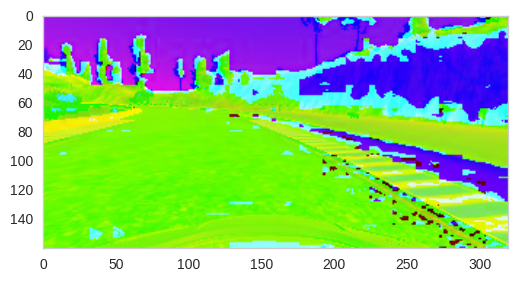

In [3]:
#img = io.imread(PATH_IMG+X_train_info[0])[50:,:,:]
img = io.imread(X_train_info[0])#[50:,:,:]
img=color.rgb2yuv(img)
plt.imshow(img)
print(img)
print(img.shape)

In [4]:
# Parameters

IMG_SIZE = (50, 100)
CHANNEL_SIZE = 3
BATCH_SIZE = 32
N_EPOCH = 1000

In [5]:
# Utility Functions
def get_formatted_image(img_path):
    img = color.rgb2yuv(io.imread(img_path)[50:,:,:])
    return transform.resize(image=img, output_shape=IMG_SIZE)

def get_single_data(index, info_tuple):
    data_x, data_y = info_tuple
    path = data_x[index]
    #path = PATH_IMG + data_x[index]
    X_img = np.ndarray(shape=(IMG_SIZE[0], IMG_SIZE[1], CHANNEL_SIZE))
    X_img = get_formatted_image(path)
    return X_img, data_y[index]

(x, y) = get_single_data(10, (X_val_info, y_val_info))
(x, y) = get_single_data(0, (X_train_info, y_train_info))
print(x.shape)
print(y)

def get_whole_data(is_train):
    if is_train is True:
        n = n_train
        info_tuple = (X_train_info, y_train_info)
    else:
        n = n_val
        info_tuple = (X_val_info, y_val_info)
    X = np.ndarray(shape=(n, IMG_SIZE[0], IMG_SIZE[1], CHANNEL_SIZE)).astype(np.float32)
    Y = np.ndarray(shape=(n, 1)).astype(np.float32)
    for i in range(n):
        x, y = get_single_data(i, info_tuple)
        if CHANNEL_SIZE == 1:
            X[i,:,:,0] = x
        else:
            X[i,:,:,:] = x
        Y[i] = y
    return X, Y


X_train, y_train = get_whole_data(is_train=True)
X_val, y_val = get_whole_data(is_train=False)

(50, 100, 3)
-0.07362056


(7527, 50, 100, 3)
(627, 50, 100, 3)


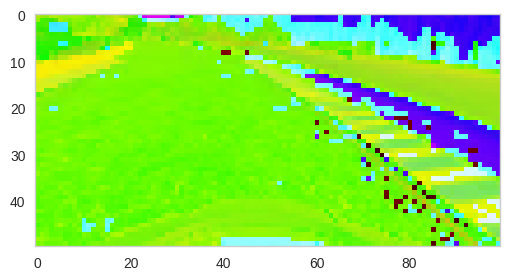

In [6]:
print(X_train.shape)
print(X_val.shape)
plt.imshow(X_train[0,:,:,:],  interpolation='nearest')

In [7]:
# Train by keras anyway
import tensorflow as tf
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Convolution2D(32, 4, 4,
                        border_mode='valid',
                        input_shape=(IMG_SIZE[0], IMG_SIZE[1], CHANNEL_SIZE),
                        dim_ordering="tf",
                        subsample=(2,2)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(64, 4, 4,
                        dim_ordering="tf",
                        subsample=(2,2)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(128, 3, 3,
                        dim_ordering="tf",
                        subsample=(1,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(400))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('tanh'))

model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 24, 49, 32)    1568        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 24, 49, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 24, 49, 32)    128         activation_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 11, 23, 64)    32832       batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [8]:
from keras.optimizers import Adam

optimizer = Adam(lr=0.0001)
model.compile(loss='mean_squared_error',
              optimizer=optimizer)

In [9]:
from keras.preprocessing.image import ImageDataGenerator
import keras

sns.set_style("darkgrid", {'axes.grid': True})

"""
cbk = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
#cbk_es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
cbk_cp = keras.callbacks.ModelCheckpoint('./models/model.h5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

model.fit_generator(data_generator(is_train=True),
                    samples_per_epoch=X_train.shape[0],
                    nb_epoch=N_EPOCH,
                    validation_data=data_generator(is_train=False),
                    nb_val_samples=X_val.shape[0],
                    callbacks=[cbk, cbk_cp])

"""

datagen = ImageDataGenerator(
    rotation_range=30.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    channel_shift_range=0.1)

# fits the model on batches with real-time data augmentation:
cbk = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
cbk_cp = keras.callbacks.ModelCheckpoint('./models/model.h5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True),
                    samples_per_epoch=len(X_train),
                    nb_epoch=N_EPOCH,
                    validation_data=(X_val, y_val),
                    nb_val_samples=len(X_val),
                    callbacks=[cbk, cbk_cp])
    
model.save('model.h5')

Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/1000


ResourceExhaustedError: OOM when allocating tensor with shape[24192,500]
	 [[Node: mul_65 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_3/read, Variable_37/read)]]

Caused by op 'mul_65', defined at:
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-5868a4c7c633>", line 34, in <module>
    callbacks=[cbk, cbk_cp])
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/keras/models.py", line 935, in fit_generator
    initial_epoch=initial_epoch)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/keras/engine/training.py", line 1450, in fit_generator
    self._make_train_function()
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/keras/engine/training.py", line 761, in _make_train_function
    self.total_loss)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/keras/optimizers.py", line 429, in get_updates
    v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 690, in _run_op
    return getattr(ops.Tensor, operator)(a._AsTensor(), *args)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 814, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 987, in _mul_dispatch
    return gen_math_ops.mul(x, y, name=name)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1613, in mul
    result = _op_def_lib.apply_op("Mul", x=x, y=y, name=name)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[24192,500]
	 [[Node: mul_65 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_3/read, Variable_37/read)]]


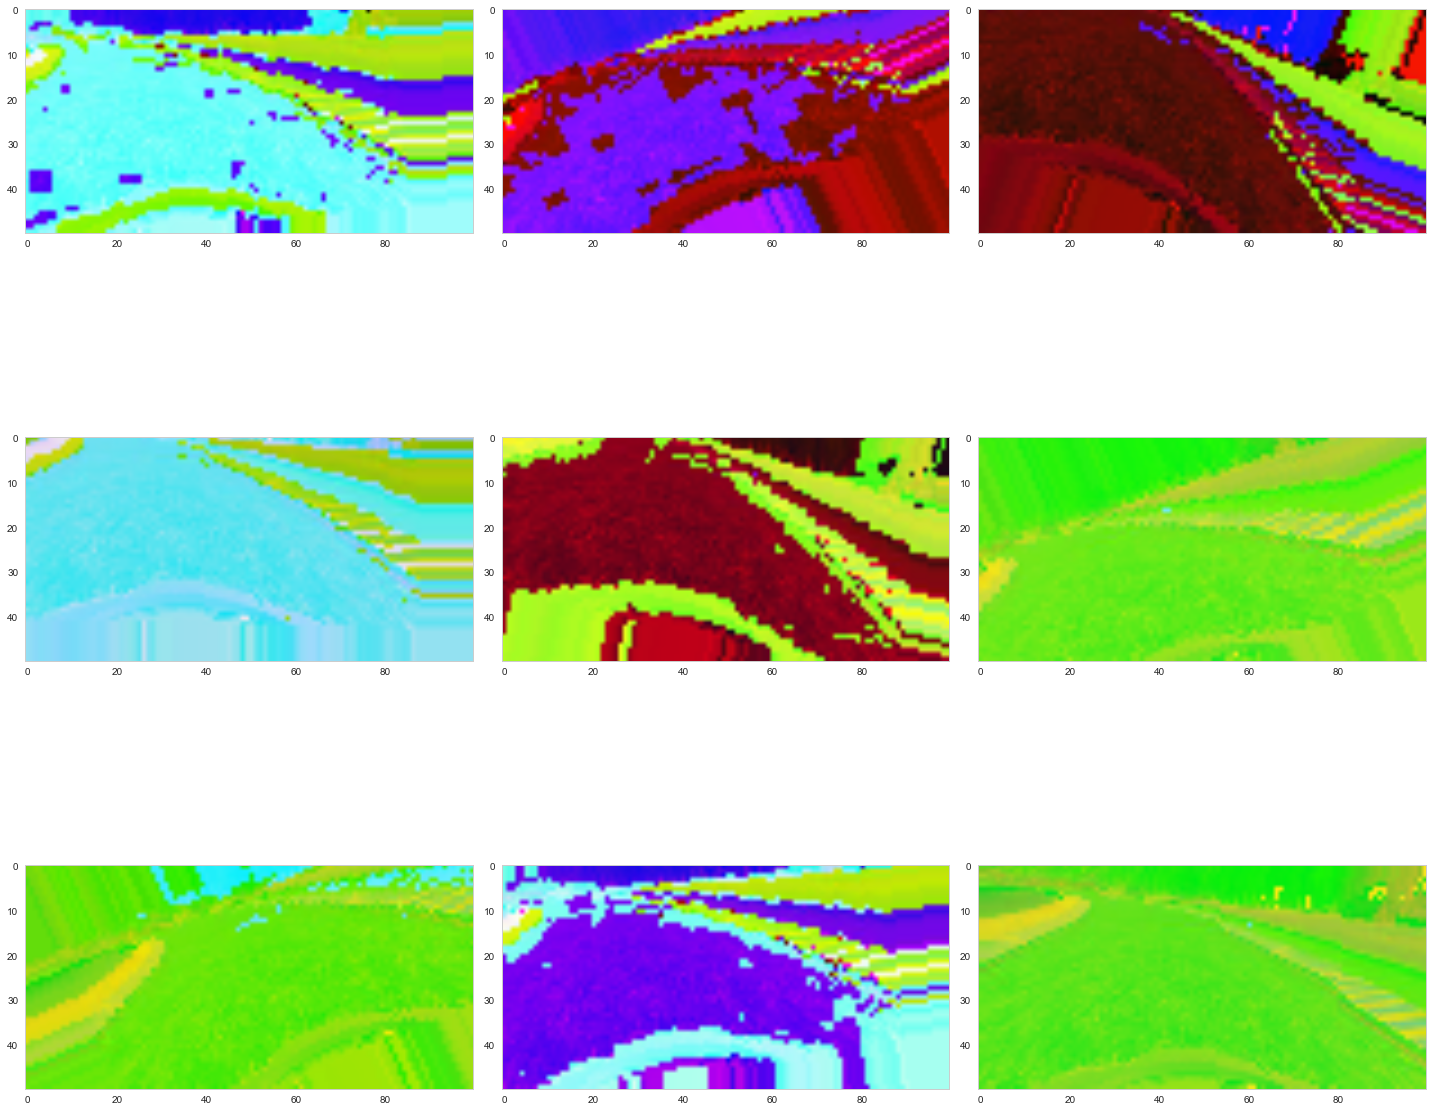

In [80]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

IMAGE_FILE = "./examples/center_2017_02_06_20_53_49_992.jpg"
IMG_SIZE = [50, 100]

def get_formatted_image():
    img = color.rgb2yuv(io.imread(IMAGE_FILE)[50:,:,:])
    #img = io.imread(IMAGE_FILE)[50:,:,:]
    return np.array([transform.resize(image=img, output_shape=IMG_SIZE)])

datagen = ImageDataGenerator(
    rotation_range=30.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    channel_shift_range=0.1)

N = 12
#plt.subplot(N, 1, 1)
#plt.imshow(io.imread(IMAGE_FILE)[50:,:,:])

img = get_formatted_image()
plt.figure(figsize=(20, 20))
#plt.subplot(N, 1, 2)
#plt.imshow(img[0])

g = datagen.flow(img, batch_size=10)
for i in range(9):
    im = g.next()
    plt.subplot(3, 3, i+1)
    plt.imshow(im[0])
plt.tight_layout()